# HappyWhale -  Whale and Dolphin Identification Model

Authors: Sharon Vaknin, Ayala Cohen

Code consists of training, validation and testing of HappyWhale model


HappyWhale architecture:
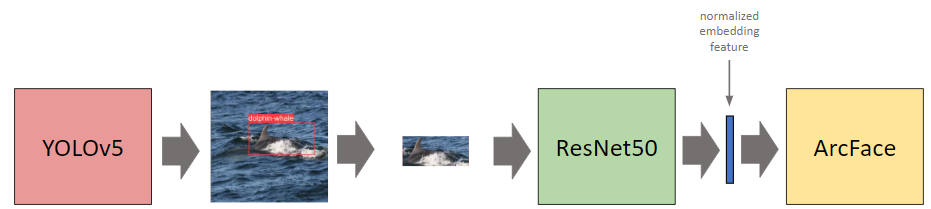


## Imports

In [1]:
!pip install metrics
from metrics import *
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras.layers import Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Conv2D
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.models import Sequential
import torch.nn as nn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.7/841.7 KB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for metrics: filename=metrics-0.3.3-py2.py3-none-any.whl size=17814 sha256=7e86fa01e2e60f62b002ac952b952f715b0f09661b8696e88864b517b283d47f
  Stored in directory: /root/.cache/pip/wheels/4f/55/f5/ca7e08a3ac083b918070e9d148ecafba8172b24611712ad678
  Created wheel for pathspec: filename=pathspec-0.5.5-py3-none-any.whl size=24234 sha256=bcfab72e4322857a115af786f87e3a0d9d3db2fedc397b47dcf253ec04c33463
  Stored in directory: /root/.cache/pip/wheels/7c/bb/0d/525cedbe683d79ee6c9185fb7e3c27d30a43141ecf89ccb46b
Successfully built metrics pathspec
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
ERROR: pip's depen

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


Configurations for our model

In [3]:
# Main project directory. Inorder to change directory, replace this
# line with the path you want:
project_dir = '/content/gdrive/MyDrive/Final_Project/Phase_B' 

# Data directory. Inside this folder are all the inputs and outputs
# of the model:
data_dir = project_dir + '/FinalCode'

class Config(object):
    train_root = data_dir +'/train/'
    valid_root = data_dir + '/validation/'
    test_root = data_dir + '/test/'

    # Configurations for YOLOv5 model
    class yolo(object):
      dataset = data_dir + '/dataset' # dataset for training yolov5
      # YOLOv5 hyperparameters:
      epochs = 1000
      batch_size = 17
      patience = 1000
      conf = 0.07

      # Path to all things related to YOLOv5 in our project:
      yolov5_dir = project_dir + '/YOLOv5' 

      # Path to the yaml file that was created in Roboflow 
      # for the detection of whales and dolphins:
      data_yaml_path = yolov5_dir + '/data.yaml'

      # Path to the trained weights of YOLOv5 model:
      weights_path  = yolov5_dir + '/yolov5_weights/weights'
      best_weights = weights_path + '/best.pt' # path to best weights after training yolov5
      cropped_images_path = data_dir + '/yolov5_results/cropped_images' # yolov5 results - cropped images
      bounding_boxes_path = data_dir + '/yolov5_results/bounding_boxes' # yolov5 results - images with bounding boxes

    # configurations for preparation of dataset for ResNet50 after detection of YoloV5
    csv_path  = data_dir + '/dataset_images.csv'
    label_target = data_dir + '/labeled_data'
    train_path = data_dir + '/yolov5_results/cropped_images'

    # configurations for ResNet50 model
    class resnet50(object):
      weights_path = data_dir + '/ResNet50/weights/resnetweights.pth'
      num_classes = 14 # number of unique whale/dolphin individuals in dataset

      # ResNet50 hyperparameters:
      epochs = 25 # We researched the following values: 25, 200, 500.
      lr = 1e-2  # initial learning rate - We researched the following values: 1e-3, 1e-2, 1e-4.
      lr_step = 10 # Period of learning rate decay.
      weight_decay = 0 # regularization technique (operates on weights)
      dropout = 0.2 # regularization technique (operates on nodes)

      train_batch_size = 64 # Batch size - We researched the following values: 32, 64
      test_batch_size = 60


config = Config()

## YOLOv5

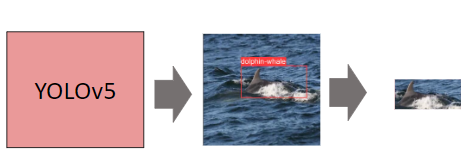

In [4]:
# clone YOLOv5 repository
%cd /content/
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 14998, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14998 (delta 0), reused 1 (delta 0), pack-reused 14995
Receiving objects: 100% (14998/14998), 14.08 MiB | 27.90 MiB/s, done.
Resolving deltas: 100% (10286/10286), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [5]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.2 MB/s eta 0:00:00
Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


Train YOLOv5 model to create bounding boxes for whales and dolphins:

In [6]:
# train yolov5s on custom data
# time its performance
%%time
%cd /content/yolov5/

# source='/myfolder/test_' + str(counter)
# run = f'python mycode.py -- source {source}'
# !{run}

train = f"python train.py --patience {config.yolo.patience} --batch {config.yolo.batch_size} --epochs {config.yolo.epochs} --data {config.yolo.data_yaml_path} --cfg ./models/yolov5l.yaml --weights '' --name yolov5l_results  --cache"
!{train}
# !python train.py --patience {config.yolo.patience} --batch {config.yolo.batch_size} --epochs {config.yolo.epochs} --data {config.yolo.data_yaml_path} --cfg ./models/yolov5l.yaml --weights '' --name yolov5l_results  --cache

Streaming output truncated to the last 5000 lines.
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:00<00:00,  1.97it/s]
                 all          9          9    0.00148      0.444    0.00598    0.00121

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     3/999     10.7G   0.09514   0.02792         0        20       640: 100% 5/5 [00:03<00:00,  1.66it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:00<00:00,  2.89it/s]
                 all          9          9    0.00148      0.444    0.00629    0.00167

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     4/999     10.7G   0.08649   0.02727         0        18       640: 100% 5/5 [00:03<00:00,  1.66it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:00<00:00,  2.91it/s]
                 all          9          9    0.00148

In [7]:
# copy weights if this is the first time running train
%cp /content/yolov5/runs/train/yolov5l_results/weights/best.pt {config.yolo.weights_path}

GROUND TRUTH TRAINING DATA:


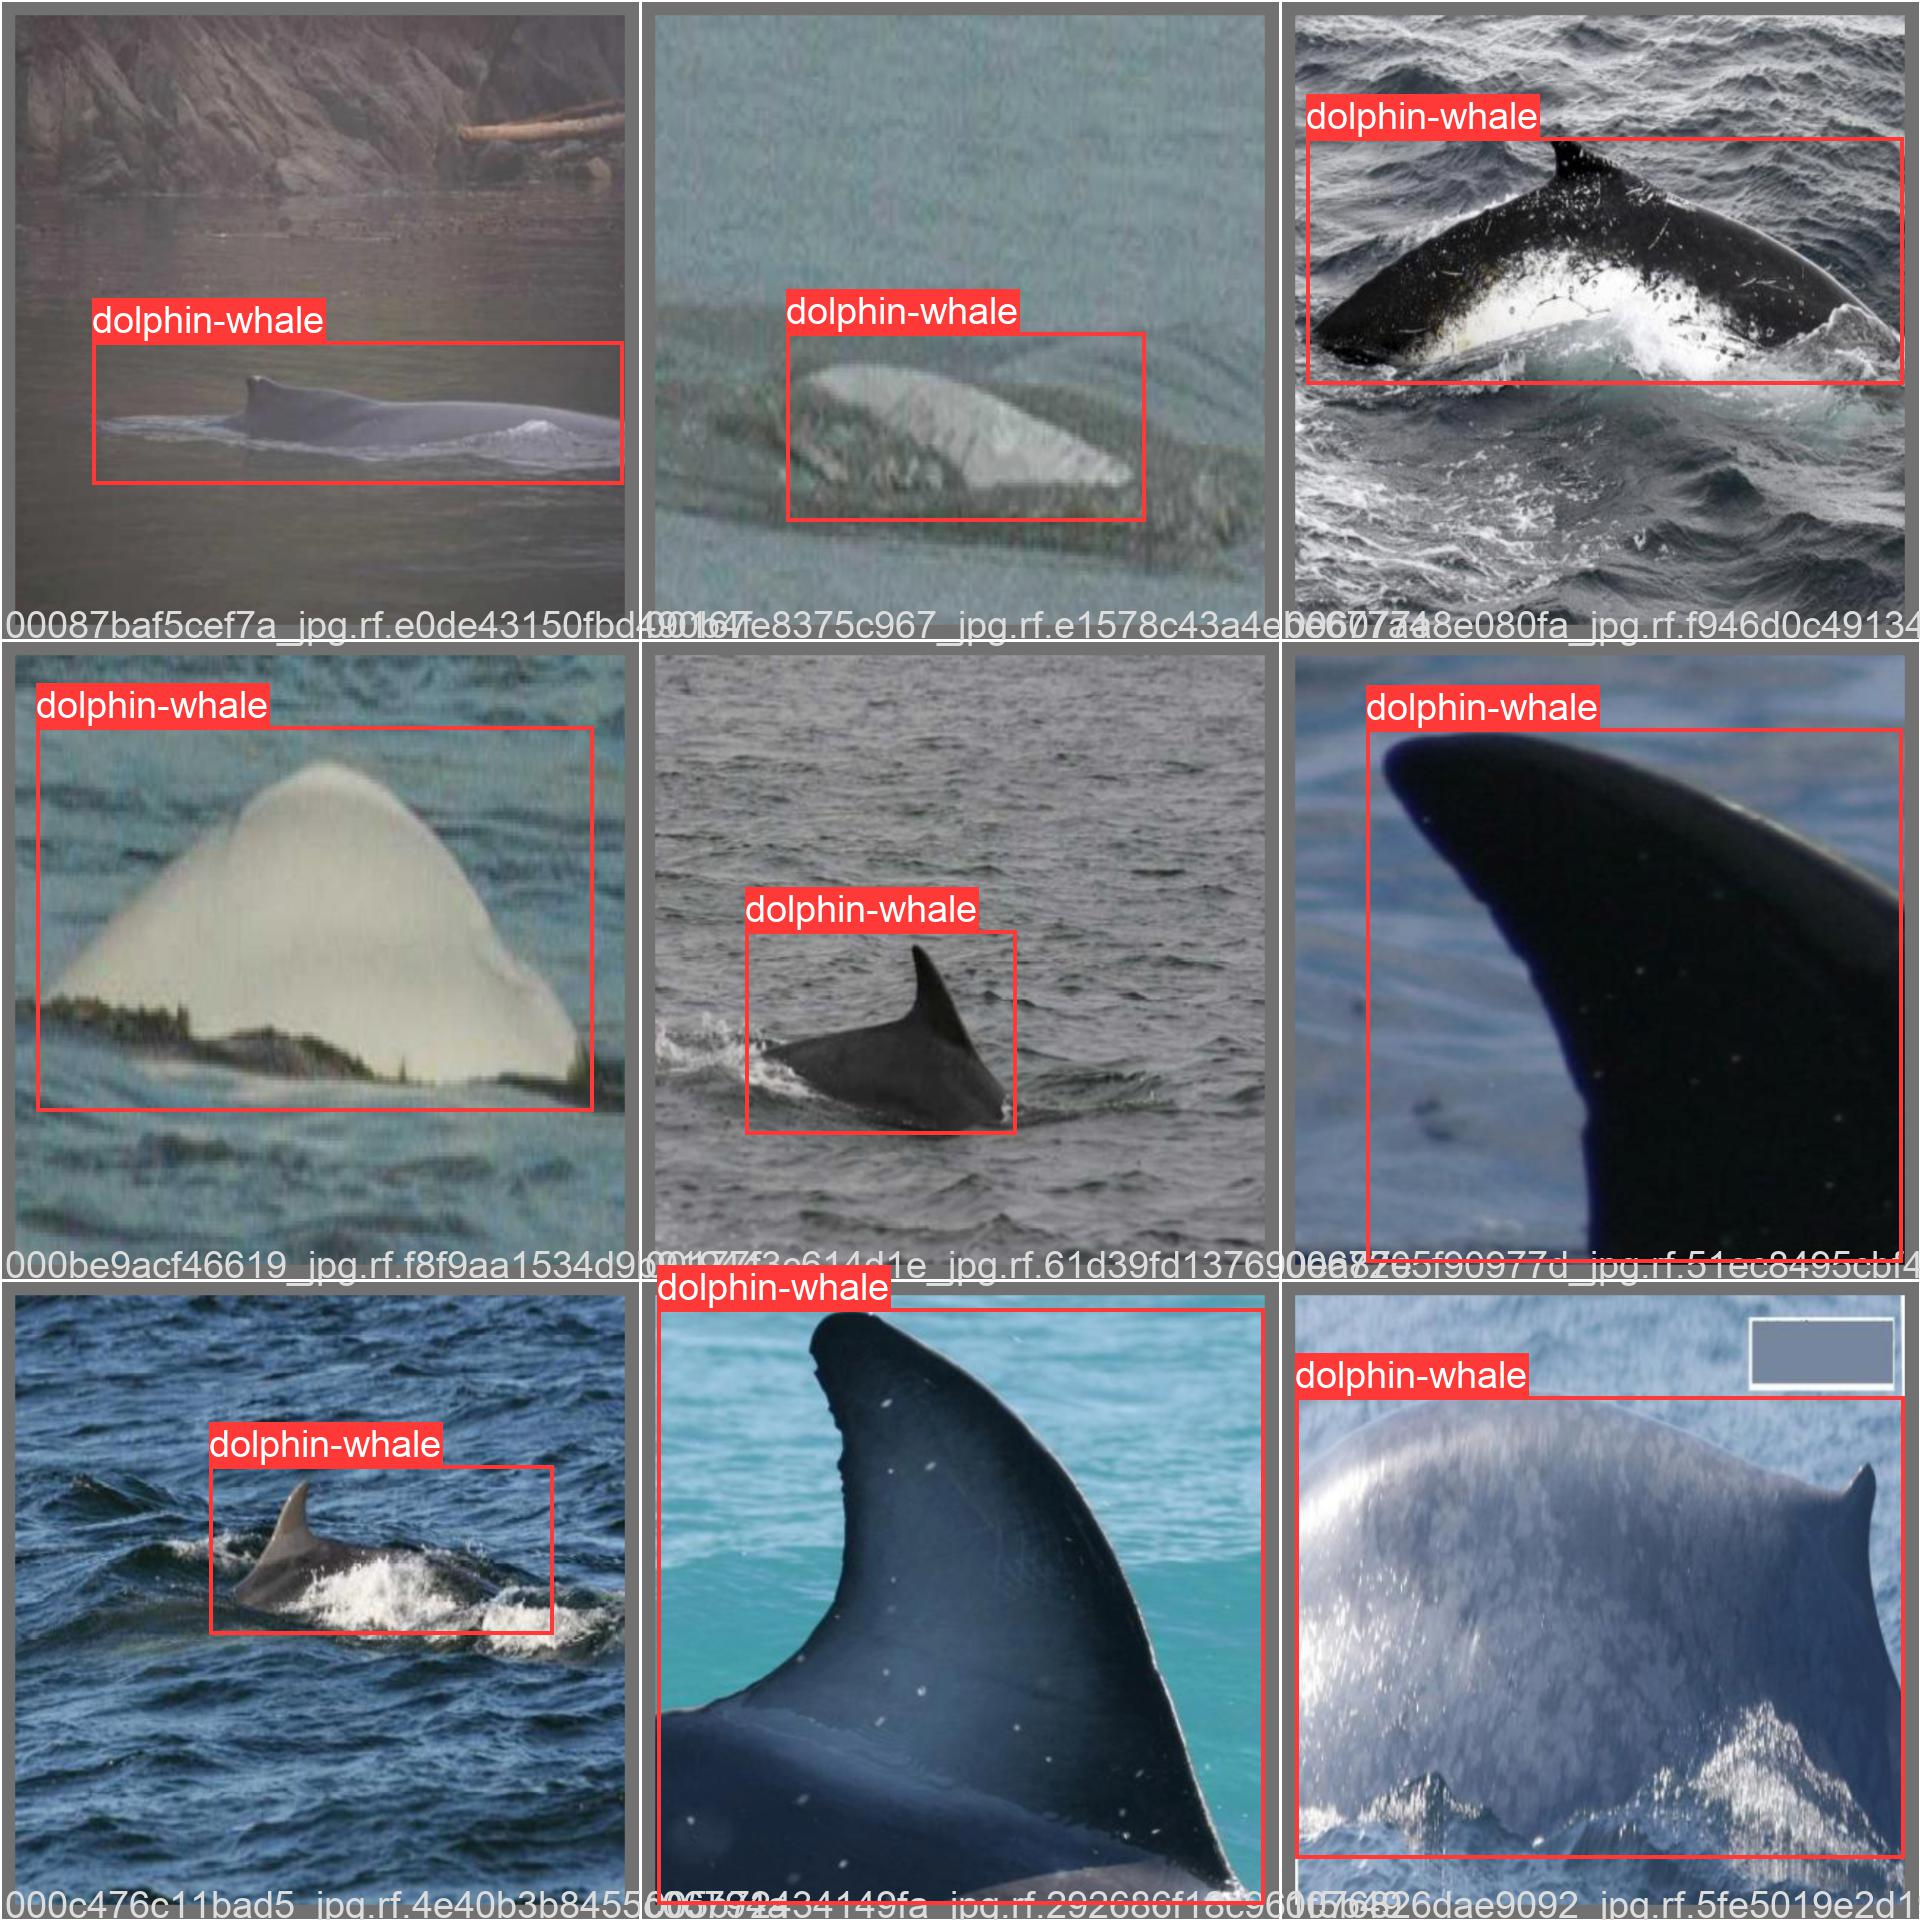

In [8]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5l_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


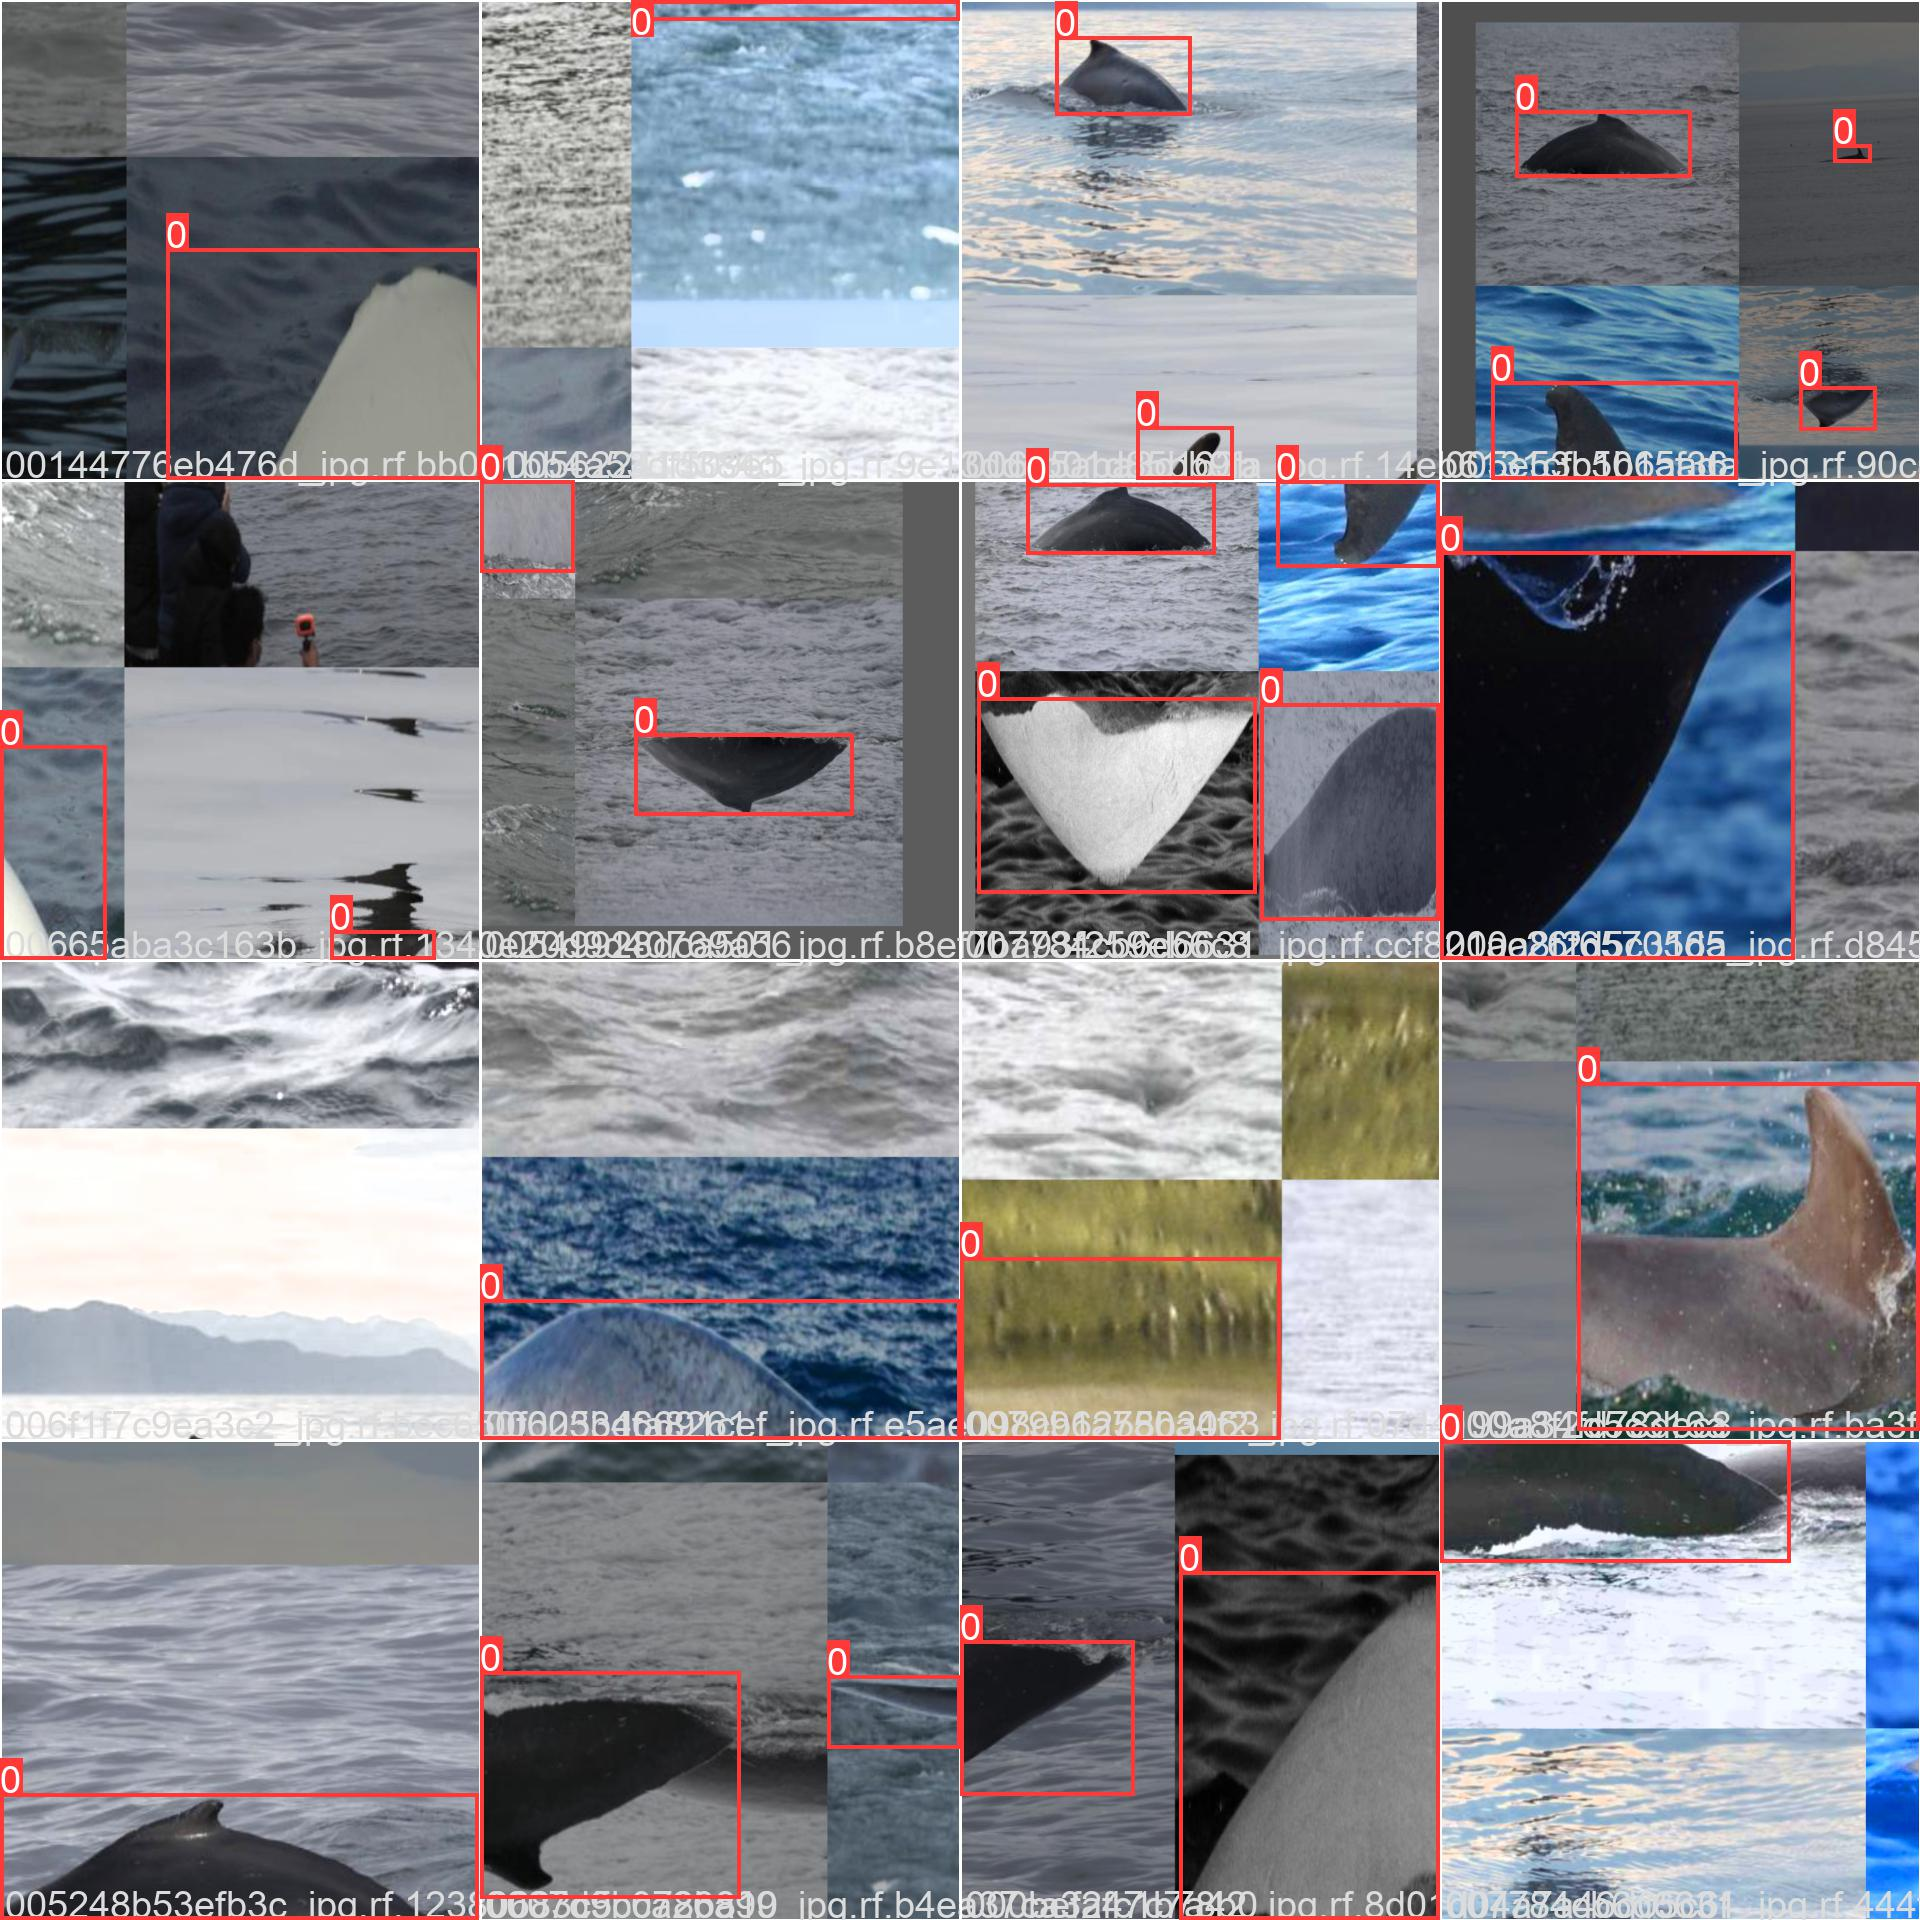

In [9]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5l_results/train_batch0.jpg', width=900)

Create bounding boxes & crop the whole dataset in preparation for ResNet50 + ArcFace:

In [10]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/

detect = f'python detect.py --weights {config.yolo.best_weights} --data {config.yolo.data_yaml_path} --conf {config.yolo.conf} --source {config.yolo.dataset} --save-crop --max-det 1'
!{detect}

/content/yolov5
detect: weights=['/content/gdrive/MyDrive/Final_Project/Phase_B/YOLOv5/yolov5_weights/weights/best.pt'], source=/content/gdrive/MyDrive/Final_Project/Phase_B/FinalCode/dataset, data=/content/gdrive/MyDrive/Final_Project/Phase_B/YOLOv5/data.yaml, imgsz=[640, 640], conf_thres=0.07, iou_thres=0.45, max_det=1, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/286 /content/gdrive/MyDrive/Final_Project/Phase_B/FinalCode/dataset/0202499d0f213c.jpg: 448x640 1 dolphin-whale, Done. (0.043s)
image 2/286 /content/gdrive/MyDrive/Final_Project/Phase_B/FinalCod

Save results to drive:

In [11]:
%rm -r {config.yolo.cropped_images_path}/*
%rm -r {config.yolo.bounding_boxes_path}/*

%cp -r /content/yolov5/runs/detect/exp/crops/dolphin-whale/* {config.yolo.cropped_images_path}
%cp -r /content/yolov5/runs/detect/exp/* {config.yolo.bounding_boxes_path}

In [12]:
print("YOLOv5 result:\nTotal number of bounding boxes:")
%ls {config.yolo.bounding_boxes_path} | wc -l
print("Total number of cropped images:")
%ls {config.yolo.cropped_images_path} | wc -l

YOLOv5 result:
Total number of bounding boxes:
287
Total number of cropped images:
262


In [13]:
%cp -r /content/yolov5/runs/train/yolov5l_results/weights {config.yolo.weights_path}

Create folder for each individual in preparation for ResNet50:

In [14]:
import csv
import pandas
import os 
import shutil

CSV_PATH  = config.csv_path 
LABEL_TARGET = config.label_target 
TRAIN_PATH = config.train_path

%rm -r {LABEL_TARGET}/*

# function creates a directory for each whale/dolphin individual and stores all their matching
# images under that directory.
def create_training_folder(csv_path=CSV_PATH, labeled_target_path=LABEL_TARGET, train_images_path=TRAIN_PATH):
  whaleDictionary = {} # whale dictionary (hashmap)

  # read CSV file containing labels their corresponding photo names
  data = pandas.read_csv(csv_path)
  value = data["individual_id"]

  # create directory for each label (individual ID)
  for v in set(value):
    whaleDictionary[v] = []
    try:
        os.mkdir(labeled_target_path + "/" + v)
    except FileExistsError:
        print('Directory {} already exists'.format(v))
    else:
        print('Directory {} created'.format(v))

  image_names = data['image']
  indvidual_ids = data['individual_id']

  # insert all images of same individual under the same directory
  for image_name, id in zip(image_names, indvidual_ids):
    whaleDictionary[id].append(image_name)

  # copy images to label files
  folder = os.fsencode(train_images_path)
  filenames = []

  for file in os.listdir(folder):
    filename = file.decode("utf-8")
    if filename.endswith( ('.jpg') ):
      original = train_images_path + "/" + filename
      print(filename)
      key = [k for k, v in whaleDictionary.items() if filename in v]
      target = labeled_target_path + "/" +  key[0] + "/" + filename
      if (os.path.exists(target) == False):
        shutil.copyfile(original, target)

create_training_folder(CSV_PATH,LABEL_TARGET,TRAIN_PATH)

Directory 02947a94c3fc created
Directory 027ac44f5b33 created
Directory 320751707094 created
Directory 541203120577 created
Directory 255682316920 created
Directory 345218493744 created
Directory 02ac4e3ca497 created
Directory 03f3d1f0e58f created
Directory 04a9b1cad4d9 created
Directory 281504409737 created
Directory 03095fb8bd05 created
Directory 03880e5855cc created
Directory 031816fd9d9d created
Directory 617368452785 created
02a5d1f5d7fe93.jpg
03b36aa5106fa2.jpg
0202499d0f213c.jpg
05413033ece042.jpg
02230215614250.jpg
0369c4c0e79846.jpg
03d1466232db68.jpg
056eea9ce3f7f3.jpg
05b79c1620d48a.jpg
05c88f19c02fe7.jpg
0b2022cc914783.jpg
0a677b4e9a6fd7.jpg
06c5256a7be5c2.jpg
06cb37429de74f.jpg
0bdf8775445e25.jpg
0bff2858f2b707.jpg
0c04b404bf8888.jpg
0c115137a6a506.jpg
0cac5d631fb628.jpg
107ba595156ae9.jpg
0c619df14d683f.jpg
10a41487849f97.jpg
13e784fd3e8906.jpg
13892eec6c9140.jpg
0c99c5d84728ff.jpg
146dc8d93affb4.jpg
0d5fc0f01895f5.jpg
0d7a68b0e4ad7f.jpg
14b35d2b2f960f.jpg
1538080cbf43a0.

Divide labeled dataset for training, validation and test:

In [15]:
# creates a directory for each label
def create_directory4label(dir_name="", label=""):
    new_dir = os.path.join(dir_name, label)

    if (os.path.exists(new_dir)):
      shutil.rmtree(new_dir)
    os.mkdir(new_dir)

    return new_dir

# divide dataset to TRAIN, VALIDATION and TEST
def divide_dataset(labeled_data_path="", validation_path="", training_path="", test_path=""): 
    
  folder = os.fsencode(labeled_data_path)

  # for each label, take 2 images for VALIDATION, 4 images for TEST, and the rest for TRAIN
  for label in os.listdir(folder):

    cnt=0

    labelname = label.decode("utf-8") # label name (individual ID)

    # create folder with label name inside validation, test and train
    valid = create_directory4label(validation_path, labelname)
    test = create_directory4label(test_path, labelname)
    train = create_directory4label(training_path, labelname)

    # divide images to validation, test and train
    for image in os.listdir( os.path.join(labeled_data_path, labelname) ):
      source = os.path.join(labeled_data_path, labelname) + "/" + image
      if (cnt < 2): # 2 images of each individual for VALIDATION
        target = valid + "/" + image
        shutil.copy(source, valid)
      elif (cnt >=2 and cnt <4): # 2 images of each individual for TEST
        target = test + "/" + image
        shutil.copy(source, test)
      else:
        target = train + "/" + image # the rest for TRAIN
        shutil.copy(source, train)      
      cnt+=1

divide_dataset(labeled_data_path=config.label_target, validation_path=config.valid_root, 
               training_path=config.train_root, test_path=config.test_root) 

## ResNet50 + ArcFace

In [16]:
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import os
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import copy

Data preparation

In [17]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = { # augmentation for dataset
    'train': transforms.Compose([ # augmentations for training data ### TODO: add padding
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([ # augmentations for validation set
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # augmentations for validation set
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = image_datasets['train'].classes

assert len(class_names) == config.resnet50.num_classes

print("Individual IDs: ", class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Individual IDs:  ['027ac44f5b33', '02947a94c3fc', '02ac4e3ca497', '03095fb8bd05', '031816fd9d9d', '03880e5855cc', '03f3d1f0e58f', '04a9b1cad4d9', '255682316920', '281504409737', '320751707094', '345218493744', '541203120577', '617368452785']


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


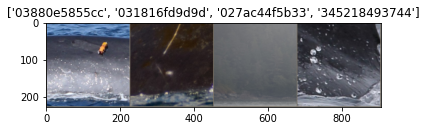

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
# train ResNet50+ArFace model
def train_model(model, arcface_loss, criterion, optimizer, scheduler, num_epochs=25):
    # variables for final graph
    val_losses = []
    train_losses = []
    train_accuracy = []
    val_accuracy = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    best_train_acc = 0.0

    epoch_acc =0.0;
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    features = model(inputs)
                    output = criterion(features, labels)
                    loss_arcface = nn.CrossEntropyLoss()(output, labels)
                    loss_ce = nn.CrossEntropyLoss()(features, labels)
                    loss = loss_arcface + loss_ce
                    _, preds = torch.max(features, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # calculate new weights
                        optimizer.step() # update weights

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step()
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc.item())
            
            if phase == 'validation':
              val_losses.append(epoch_loss)
              val_accuracy.append(epoch_acc.item())
           
            
            print('{} Loss: {:.4f} {} Acc: {:.4f}'.format(
                phase, epoch_loss, phase, epoch_acc))

              # deep copy the model
            if phase == 'validation' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

              # deep copy the model
            elif phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Acc: {:4f}'.format(best_val_acc))
    print('Best Training Acc: {:4f}'.format(best_train_acc))

    # plot training vs. accuracy
    print(len(val_losses))
    print(len(train_losses))
    # plt.figure(figsize=(10,5))
    plt.title("Training and Validation loss")
    plt.plot(val_losses,label="Validation")
    plt.plot(train_losses,label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.title("Training and Validation accuracy")
    plt.plot(val_accuracy,label="Validation")
    plt.plot(train_accuracy,label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)

    # save weights in drive
    torch.save(model.state_dict(), config.resnet50.weights_path)

    return model

In [20]:
def visualize_model(model, num_images=6): # training function
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            features = model(inputs)
            output = criterion(features, labels)
            loss_arcface = nn.CrossEntropyLoss()(output, labels)
            loss_ce = nn.CrossEntropyLoss()(features, labels)
            loss = loss_arcface + loss_ce
            _, preds = torch.max(features, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted ID: {class_names[preds[j]]}\nTarget ID: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
%cd '/content/'
!git clone https://github.com/4uiiurz1/keras-arcface.git
!git clone https://github.com/ahmedbesbes/whales-classification.git

/content
Cloning into 'keras-arcface'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), 450.68 KiB | 14.08 MiB/s, done.
Cloning into 'whales-classification'...
remote: Enumerating objects: 2163, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 2163 (delta 100), reused 107 (delta 45), pack-reused 1997
Receiving objects: 100% (2163/2163), 264.90 MiB | 48.77 MiB/s, done.
Resolving deltas: 100% (518/518), done.
Updating files: 100% (964/964), done.


In [22]:
%cd /content/whales-classification

/content/whales-classification


In [23]:
from losses.arcface import ArcMarginProduct
from torch.optim.lr_scheduler import StepLR
from torch.nn import DataParallel
from torch.optim import Adam

num_classes = config.resnet50.num_classes # number of unique individuals in our dataset

model_ft = models.resnet50(pretrained=True) # we are using transfer learning in our mode, trained on ImageNET
num_ftrs = model_ft.fc.in_features

model_ft.avgpool = nn.AdaptiveAvgPool2d(1)

model_ft.fc = nn.Linear(num_ftrs, num_classes) # our fully connected layer that we will be training
model_ft.dropout = nn.Dropout(config.resnet50.dropout)

arcface_loss = ArcMarginProduct(in_features=14, out_features=num_classes, s=30, m=0.5, easy_margin=False)
criterion = arcface_loss

print(model_ft) 
model_ft = model_ft.to(device)
arcface_loss.to(device)
arcface_loss = DataParallel(arcface_loss)

optimizer = torch.optim.Adam([{'params': model_ft.fc.parameters()}, {'params': arcface_loss.parameters()}],
                                     lr=config.resnet50.lr, weight_decay=config.resnet50.weight_decay)
scheduler = StepLR(optimizer, step_size=config.resnet50.lr_step, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch 0/24
----------
train Loss: 37.7519 train Acc: 0.1456
validation Loss: 40.8351 validation Acc: 0.1429

Epoch 1/24
----------
train Loss: 25.8643 train Acc: 0.2670
validation Loss: 32.1038 validation Acc: 0.1786

Epoch 2/24
----------
train Loss: 21.8719 train Acc: 0.2718
validation Loss: 32.0493 validation Acc: 0.2857

Epoch 3/24
----------
train Loss: 20.7711 train Acc: 0.3350
validation Loss: 27.5519 validation Acc: 0.3214

Epoch 4/24
----------
train Loss: 20.0343 train Acc: 0.3058
validation Loss: 24.9285 validation Acc: 0.3929

Epoch 5/24
----------
train Loss: 18.1014 train Acc: 0.3689
validation Loss: 22.1134 validation Acc: 0.3571

Epoch 6/24
----------
train Loss: 14.3452 train Acc: 0.4854
validation Loss: 17.8431 validation Acc: 0.4286

Epoch 7/24
----------
train Loss: 11.1150 train Acc: 0.4903
validation Loss: 16.0432 validation Acc: 0.4643

Epoch 8/24
----------
train Loss: 12.6713 train Acc: 0.3689
validation Loss: 17.7329 validation Acc: 0.4643

Epoch 9/24
--------

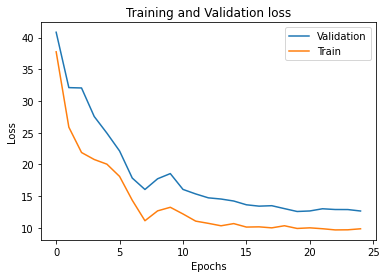

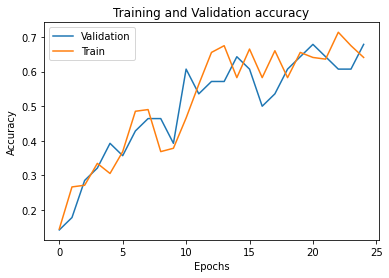

In [24]:
# Train our model
HappyWhale = train_model(model_ft, arcface_loss, criterion, optimizer, scheduler,
                       num_epochs=config.resnet50.epochs)

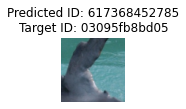

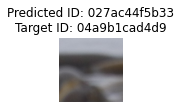

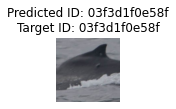

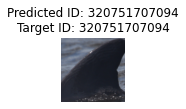

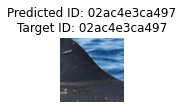

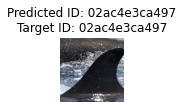

In [25]:
visualize_model(HappyWhale) # Test